In [1]:
import torch
import numpy as np
import os
import cv2
import torchvision.transforms as T
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import random

from torchsummary import summary
from tqdm.notebook import tqdm
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split
from typing import Callable, Optional, Sequence
from urllib.parse import urlencode
from yacs.config import CfgNode as CN
from torch.utils.tensorboard import SummaryWriter
from tqdm.notebook import tqdm
from torchmetrics import CharErrorRate

In [2]:
seed = 42

torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

In [3]:
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 1. Подготовка данных

Нужно реализовать класс данных (наследник torch.utils.data.Dataset). Класс должен считывать входные изображения и выделять метки из имён файлов. Для чтения изображений предлагается использовать библиотеку OpenCV (методы cv2.imread, cv2.resize и cv2.cvtColor). В базовом варианте достаточно загрузить тренировочную и тестовую части корпуса. Можно также отделить валидационный корпус от тренировочного. Также предлагается реализовать механизм аугментаций для повышения качества обучения.

In [4]:
dataset_root = 'data/CCPD2019-dl1'

dataset_train_path = os.path.join(dataset_root, 'train')
dataset_test_path = os.path.join(dataset_root, 'test')

In [5]:
vocab = set()

# create vocab
for part in os.listdir(dataset_root):
    for filename in tqdm(os.listdir(os.path.join(dataset_root, part))):
        target = filename.split('-')[1].replace('.jpg', '')
        for token in target:
            vocab.update(token)
    
# set to list
vocab_list = list(vocab)
# spec token
vocab_list.append('-')
vocab_list.sort()

# set to list
vocab = {token:i for i, token in enumerate(vocab_list)}
index2token = {i:token for i, token in enumerate(vocab_list)}

  0%|          | 0/9999 [00:00<?, ?it/s]

  0%|          | 0/199980 [00:00<?, ?it/s]

In [6]:
class LPDataset(Dataset):
    def __init__(self,
                 root: str,
                 vocab: dict[str, int],
                 plate_transforms: Optional[Callable[[torch.Tensor], torch.Tensor]] = None) -> None:
        assert os.path.exists(root), 'Path to data incorrect!'
        
        self.root = root
        self.imgs = np.array(os.listdir(root))
        self.vocab = vocab
        self.transforms = plate_transforms
        
    def __len__(self) -> int:
        return len(self.imgs)
    
    def __getitem__(self, index) -> tuple[torch.Tensor, torch.Tensor, int]:
        filename = self.imgs[index]
        image = cv2.cvtColor(cv2.imread(os.path.join(self.root, filename)), cv2.COLOR_BGR2RGB)
        image = torch.tensor(np.transpose(image.astype(np.float32), (2, 0, 1)))

        # transform image
        if self.transforms:
            image = self.transforms(image)
        
        tokens = []
        target = filename.split('-')[1].replace('.jpg', '')
        for token in target:
            tokens.append(self.vocab[token])
        
        return image, torch.tensor(tokens, dtype=torch.long), len(target)

In [7]:
transforms = {'train': T.Compose([T.Resize((24, 94), antialias=False), T.Normalize((127.5, 127.5, 127.5), (128, 128, 128))]),
              'test': T.Compose([T.Resize((24, 94), antialias=False), T.Normalize((127.5, 127.5, 127.5), (128, 128, 128))])}

def denormalize(img: torch.Tensor) -> np.ndarray:
    if img.ndim == 3:
        # unbatched
        return ((img.numpy() / 0.0078125) + 127.5).astype(np.uint8).transpose((1, 2, 0))
    elif img.ndim == 4:
        # batched
        batch_size = img.shape[0]
        denormalized_images = np.empty((batch_size, img.shape[2], img.shape[3], img.shape[1]), dtype=np.uint8)
        for i in range(batch_size):
            denormalized_images[i] = ((img[i].numpy() / 0.0078125) + 127.5).astype(np.uint8).transpose((1, 2, 0))
        return denormalized_images
    else:
        raise ValueError("Invalid input shape. Expected 3 or 4 dimensions.")

train_dataset = LPDataset(dataset_train_path, vocab=vocab, plate_transforms=transforms['train'])
test_dataset = LPDataset(dataset_test_path, vocab=vocab, plate_transforms=transforms['test'])

In [8]:
def show_random_image(dataset: Callable[[int], tuple[torch.Tensor, torch.Tensor, int]]):
    index = random.randint(0, len(dataset))
    image, plate, _ = dataset[index]

    plt.imshow(denormalize(image))
    plt.title(''.join([index2token[int(index)] for index in plate]));

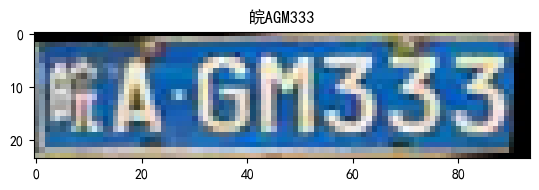

In [9]:
show_random_image(dataset=train_dataset)

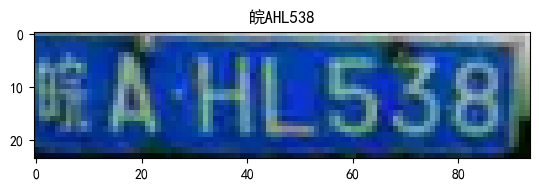

In [10]:
show_random_image(dataset=test_dataset)

In [11]:
train_indices, val_indices  = train_test_split(
                                               range(len(train_dataset)),
                                               test_size=0.2,
                                               random_state=42
                                              )

train_subset = Subset(train_dataset, train_indices)
val_subset = Subset(train_dataset, val_indices)

In [12]:
train_dataloader = DataLoader(train_dataset, shuffle=False, batch_size=128, num_workers=1)
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=128, num_workers=1)

In [13]:
def show_batch(dataloader: DataLoader, rows=8, cols=8):
    x, y, l = next(iter(train_dataloader))
    x = denormalize(x)

    num_rows = rows
    num_cols = cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 8))

    for i, ax in enumerate(axes.flat):
        if i <  x.shape[0]:
            img = x[i]
            ax.imshow(img)
            ax.set_title(''.join([index2token[int(index)] for index in y[i]]), fontsize=10)
            ax.axis('off')
        else:
            ax.axis('off')
    plt.show()

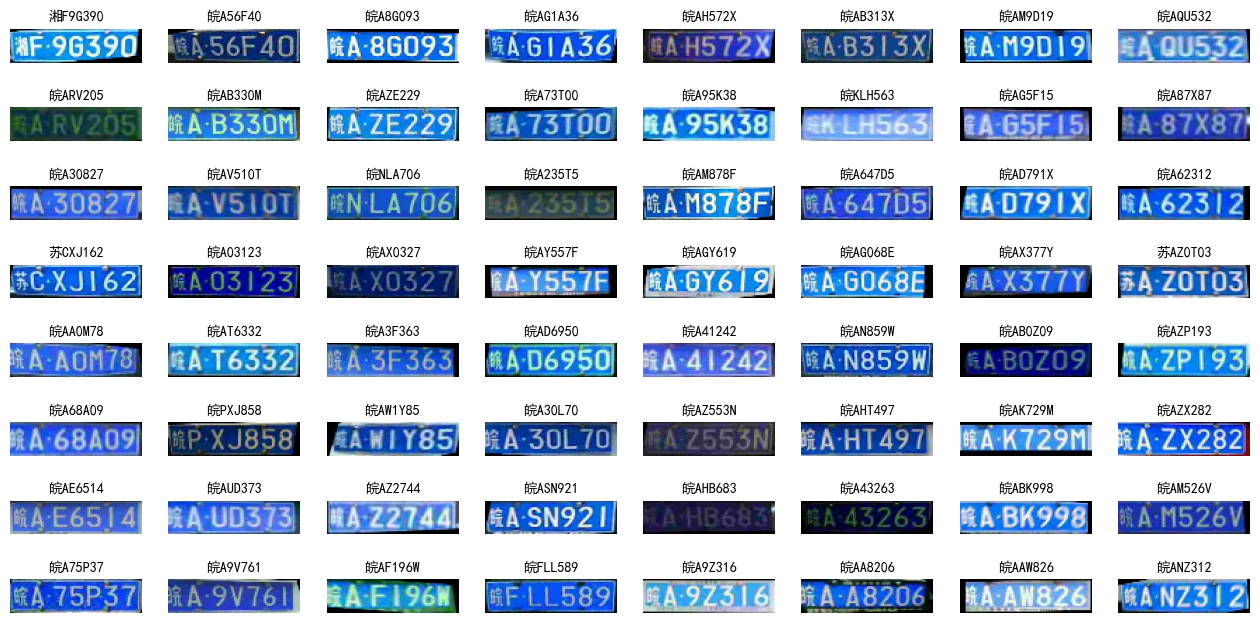

In [14]:
show_batch(train_dataloader)

# 2. Создание и обучение модели

Код модели должен быть реализован через слои стандартной библиотеки torch (torchvision.models и аналоги использовать нельзя). Поскольку число символов в номерах фиксировано, можно использовать обычный кросс-энтропийный критерий. Желающие могут использовать и CTC-loss. Цикл обучения можно реализовать самостоятельно или воспользоваться библиотеками PyTorch Lightning / Catalyst.

In [27]:
class SmallBasicBlock(nn.Module):
    """Implementation of Small Basic Block

    Args:
        in_channels (int): Number of channels in the input feature map
        out_channels (int): Number of channels in the output of Basic Block
    """
    def __init__(self, in_channels: int, out_channels: int):
        super(SmallBasicBlock, self).__init__()
        intermediate_channels = out_channels // 4

        self.block = nn.Sequential(
            nn.Conv2d(in_channels, intermediate_channels, kernel_size=1, stride=1),
            nn.ReLU(),
            nn.Conv2d(intermediate_channels, intermediate_channels, kernel_size=(3, 1), padding=(1, 0)),
            nn.ReLU(),
            nn.Conv2d(intermediate_channels, intermediate_channels, kernel_size=(1, 3), padding=(0, 1)),
            nn.ReLU(),
            nn.Conv2d(intermediate_channels, out_channels, kernel_size=1, bias=False)
        )

    def forward(self, x):
        return self.block(x)

Model taken from here: https://arxiv.org/pdf/1806.10447.pdf

In [28]:
class LPRNet(nn.Module):
    """Licence Plate Recognition Network

    Args:
        class_num (int): Corresponds to the number of all possible characters
        dropout_prob (float): Probability of an element to be zeroed in nn.Dropout
        out_indices (Sequence[int]): Indices of layers, where we want to extract feature maps and use it 
            for embedding in global context
    """
    def __init__(self, 
                 class_num: int,
                 dropout_prob: float,
                 out_indices: Sequence[int]):
        super(LPRNet, self).__init__()

        self.class_num = class_num
        self.out_indices = out_indices

        self.backbone = nn.ModuleList([
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, bias=False),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),  # -> extract feature map (2)
            nn.MaxPool3d(kernel_size=(1, 3, 3), stride=(1, 1, 1)),

            SmallBasicBlock(in_channels=64, out_channels=128),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),  # -> extract feature map (6)
            nn.MaxPool3d(kernel_size=(1, 3, 3), stride=(2, 1, 2)),
            
            SmallBasicBlock(in_channels=64, out_channels=256),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            SmallBasicBlock(in_channels=256, out_channels=256),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),  # -> extract feature map (13)
            nn.MaxPool3d(kernel_size=(1, 3, 3), stride=(4, 1, 2)),
            nn.Dropout(dropout_prob),
            
            nn.Conv2d(in_channels=64, out_channels=256, kernel_size=(1, 4), stride=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            
            nn.Conv2d(in_channels=256, out_channels=class_num, kernel_size=(13, 1), stride=1),
            nn.BatchNorm2d(num_features=self.class_num),
            nn.ReLU(),  # -> extract feature map (22)
        ])
        # in_channels - sum of all channels in extracted feature maps (see the marks above)
        self.container = nn.Conv2d(in_channels=64 + 128 + 256 + self.class_num,
                                   out_channels=self.class_num,
                                   kernel_size=(1, 1),
                                   stride=(1, 1))

    def forward(self, x) -> torch.Tensor:
        extracted_feature_maps = list()
        for i, layer in enumerate(self.backbone):
            x = layer(x)
            if i in self.out_indices:
                extracted_feature_maps.append(x)

        global_contex_emb = list()
        for i, feature_map in enumerate(extracted_feature_maps):
            if i in (0, 1):
                feature_map = nn.AvgPool2d(kernel_size=5, stride=5)(feature_map)
            if i == 2:
                feature_map = nn.AvgPool2d(kernel_size=(4, 10), stride=(4, 2))(feature_map)
            f_pow = torch.pow(feature_map, 2)
            f_mean = torch.mean(f_pow)
            feature_map = torch.div(feature_map, f_mean)
            global_contex_emb.append(feature_map)

        x = torch.cat(global_contex_emb, 1)
        x = self.container(x)
        logits = torch.mean(x, dim=2)
        return logits

In [29]:
lprnet = LPRNet(class_num=67, 
                dropout_prob=0.5,
                out_indices=(2, 6, 13, 22))

summary(lprnet, (3, 24, 94), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 22, 92]           1,728
       BatchNorm2d-2           [-1, 64, 22, 92]             128
              ReLU-3           [-1, 64, 22, 92]               0
         MaxPool3d-4           [-1, 64, 20, 90]               0
            Conv2d-5           [-1, 32, 20, 90]           2,080
              ReLU-6           [-1, 32, 20, 90]               0
            Conv2d-7           [-1, 32, 20, 90]           3,104
              ReLU-8           [-1, 32, 20, 90]               0
            Conv2d-9           [-1, 32, 20, 90]           3,104
             ReLU-10           [-1, 32, 20, 90]               0
           Conv2d-11          [-1, 128, 20, 90]           4,096
  SmallBasicBlock-12          [-1, 128, 20, 90]               0
      BatchNorm2d-13          [-1, 128, 20, 90]             256
             ReLU-14          [-1, 128,

In [30]:
input_example, _, _ = next(iter(test_dataloader))
with torch.no_grad():
    output_example = lprnet(input_example)
print('Input shape: ', input_example.shape)
print('Output shape: ', output_example.shape)

Input shape:  torch.Size([128, 3, 24, 94])
Output shape:  torch.Size([128, 67, 18])


In [31]:
class Decoder:
    """Interface for sequence decoding"""
    def decode(self, predicted_seq, chars_list):
        raise NotImplementedError


class GreedyDecoder(Decoder):
    def decode(self, predicted_seq, chars_list):
        full_pred_labels = []
        labels = []
        # predicted_seq.shape = [batch, len(chars_list), len_seq]
        for i in range(predicted_seq.shape[0]):
            single_prediction = predicted_seq[i, :, :]
            predicted_labels = []
            for j in range(single_prediction.shape[1]):
                predicted_labels.append(np.argmax(single_prediction[:, j], axis=0))

            without_repeating = []
            current_char = predicted_labels[0]
            if current_char != len(chars_list) - 1:
                without_repeating.append(current_char)
            for c in predicted_labels:
                if (current_char == c) or (c == len(chars_list) - 1):
                    if c == len(chars_list) - 1:
                        current_char = c
                    continue
                without_repeating.append(c)
                current_char = c

            full_pred_labels.append(without_repeating)

        for i, label in enumerate(full_pred_labels):
            decoded_label = ''
            for j in label:
                decoded_label += chars_list[j]
            labels.append(decoded_label)

        return labels, full_pred_labels


class BeamDecoder(Decoder):
    def decode(self, predicted_seq, chars_list):
        labels = []
        final_labels = []
        final_prob = []
        k = 1
        for i in range(predicted_seq.shape[0]):
            sequences = [[list(), 0.0]]
            all_seq = []
            single_prediction = predicted_seq[i, :, :]
            for j in range(single_prediction.shape[1]):
                single_seq = []
                for char in single_prediction[:, j]:
                    single_seq.append(char)
                all_seq.append(single_seq)

            for row in all_seq:
                all_candidates = []
                for i in range(len(sequences)):
                    seq, score = sequences[i]
                    for j in range(len(row)):
                        candidate = [seq + [j], score - row[j]]

                        all_candidates.append(candidate)
                ordered = sorted(all_candidates, key=lambda tup: tup[1])
                # select k best
                sequences = ordered[:k]

            full_pred_labels = []
            probs = []
            for i in sequences:

                predicted_labels = i[0]
                without_repeating = []
                current_char = predicted_labels[0]
                if current_char != len(chars_list) - 1:
                    without_repeating.append(current_char)
                for c in predicted_labels:
                    if (current_char == c) or (c == len(chars_list) - 1):
                        if c == len(chars_list) - 1:
                            current_char = c
                        continue
                    without_repeating.append(c)
                    current_char = c

                full_pred_labels.append(without_repeating)
                probs.append(i[1])
            for i, label in enumerate(full_pred_labels):
                decoded_label = ''
                for j in label:
                    decoded_label += chars_list[j]
                labels.append(decoded_label)
                final_prob.append(probs[i])
                final_labels.append(full_pred_labels[i])

        return labels, final_prob, final_labels

In [32]:
beam_decoder = BeamDecoder()
preds = output_example.cpu().detach().numpy()
print(beam_decoder.decode(preds, vocab_list))
greedy_decoder = GreedyDecoder()
print(greedy_decoder.decode(preds, vocab_list))

(['吉皖蒙皖蒙皖蒙皖', '桂G云G闽桂G云闽G闽皖云', 'H鲁H', 'H津H', '鲁H鲁H鲁', '云湘云湘云湘2云湘云湘云湘云湘', '云贵云湘C云湘H云湘鲁湘浙鲁', '鲁湘浙鲁湘C鲁云津鲁云浙鲁浙鲁', '鲁H浙H鲁H鲁H', '鲁浙湘C鲁C浙鲁浙鲁浙鲁浙鲁', '2Z云2桂云Z桂ZN2Z2', '贵云贵云16闽G贵云贵云闽云', '桂吉蒙吉皖蒙皖蒙皖蒙皖蒙皖', '浙湘浙鲁湘H湘鲁湘鲁', '皖C蒙C蒙湘C蒙新HC新蒙H', '吉皖蒙皖蒙新皖蒙皖新皖新桂蒙皖', '浙云浙云C云鲁浙鲁浙鲁津鲁', 'CHC云湘C湘津湘琼津湘津湘津云湘', 'Z桂Z2桂Z桂Z贵Z', '鲁湘C鲁C鲁湘浙鲁浙鲁浙鲁', '湘C湘C湘C湘', 'C津C鲁湘C鲁浙鲁C鲁C鲁', 'Z桂1GZG桂G桂G桂G桂G川', '琼湘6云湘6云湘云湘5湘琼5', '闽皖闽M闽云闽桂G闽桂新G', 'H1H鲁H鲁', '鲁C鲁C浙鲁浙鲁浙鲁浙鲁浙鲁', '皖闽皖闽G闽G闽', 'H', '鲁津鲁浙鲁浙鲁', '桂云闽皖云闽G闽G5闽5湘', '桂皖闽桂皖闽皖闽', '云浙云津浙鲁浙云浙云鲁浙云鲁', 'H', 'H鲁H', 'ZN2桂贵桂Z桂Z桂Z', '云湘云湘云湘云湘云湘', 'H皖C吉皖1皖蒙吉皖吉皖', '云闽云湘云贵云闽云湘云Q', 'C皖C新C皖蒙新皖C赣湘C皖C赣湘', '鲁浙鲁C鲁C鲁C鲁津鲁', '闽云闽云闽皖闽琼云闽', '浙云浙鲁C浙鲁浙鲁', 'Q云C云C皖蒙C皖湘蒙云蒙闽Q云', '闽新闽G闽', '鲁H鲁H浙鲁H鲁C鲁H鲁H吉鲁', '鲁吉云琼浙云2吉鲁津浙云', 'H鲁H鲁H', '新H吉皖1C新皖H皖C皖H皖CH', '琼湘琼皖湘5云蒙B吉蒙2湘', '浙云津云浙云浙云浙云浙云', '桂G闽皖云闽桂闽皖G闽G桂G', '鲁-鲁-鲁', '桂2皖贵2桂贵闽云2N2桂', '津2湘云湘云B云2云', 'H湘H湘吉鲁浙吉鲁', '云津云浙云浙云', '琼湘琼云湘琼湘云', '鲁H鲁H鲁H鲁H鲁', '鲁C浙鲁C浙鲁', '云鲁云鲁云鲁云鲁浙鲁', '琼5湘云湘云湘5湘云湘', '云2云2云2云闽湘琼云5云', '蒙皖蒙', '蒙皖蒙皖蒙皖蒙皖蒙', '皖湘皖湘琼皖琼5琼蒙5琼云6琼皖', '皖新吉皖吉皖吉皖吉皖', 'H', '鲁H鲁H鲁H', '鲁湘C鲁湘C鲁

### Config

In [33]:
_C = CN()

# Root dir (different for PC and Server)
_C.ROOT = CN()
_C.ROOT.PATH = '.'  # LPR project dir

# Chars parameters
_C.CHARS = CN()
# List of all possible characters
_C.CHARS.LIST = vocab_list

# LPRNet
_C.LPRNet = CN()
_C.LPRNet.DROPOUT = 0.5  # Dropout probability
_C.LPRNet.OUT_INDEXES = (2, 6, 13, 22)  # Indices of layers, where we want to extract feature maps and use it
                                        # for embedding in global context
_C.LPRNet.PREDICTED_LENGTHS = 18  # Predicted sequence length

# Train LPRNet
_C.LPRNet.TRAIN = CN()
_C.LPRNet.TRAIN.OUT_FOLDER = 'checkpoints'  # Checkpoints folder
_C.LPRNet.TRAIN.PRETRAINED_MODEL = None  # Pretrained LPR model (.pth)
_C.LPRNet.TRAIN.BATCH_SIZE = 128  # Batch size
_C.LPRNet.TRAIN.NUM_WORKERS = 4  # Num worker
_C.LPRNet.TRAIN.NUM_EPOCHS = 15  # Number of training epochs
_C.LPRNet.TRAIN.SAVE_PERIOD = 1  # How often to save model weights (epoch)
_C.LPRNet.TRAIN.LR = 0.01  # Initial train learning rate
_C.LPRNet.TRAIN.LR_SHED_GAMMA = 0.99  # Gamma for ExponentialLR sheduler
_C.LPRNet.TRAIN.MIN_LR = 0.0001  # Min Learning rate
_C.LPRNet.TRAIN.CTC_REDUCTION = 'mean'  # Reduction: 'none' | 'mean' | 'sum'

def get_cfg_defaults():
    return _C.clone()

In [34]:
# -------------------
# Dataloaders
# -------------------

def create_datasets():
    return {'train': train_subset,
            'val': val_subset,
            'test': test_dataset}

def collate_fn(batch):
    images = []
    labels = []
    lengths = []
    for sample in batch:
        img, label, length = sample
        images.append(img)
        labels.extend(label)
        lengths.append(length)
    labels = torch.stack(labels).flatten()
    return torch.stack(images), labels, lengths


def create_dataloaders(datasets, config):
    train_dataloader = DataLoader(datasets['train'],
                                  shuffle=True,
                                  batch_size=config.LPRNet.TRAIN.BATCH_SIZE,
                                  num_workers=config.LPRNet.TRAIN.NUM_WORKERS,
                                  collate_fn=collate_fn,
                                  pin_memory=True)
    val_dataloader = DataLoader(datasets['val'],
                                shuffle=False,
                                batch_size=config.LPRNet.TRAIN.BATCH_SIZE,
                                num_workers=config.LPRNet.TRAIN.NUM_WORKERS,
                                collate_fn=collate_fn,
                                pin_memory=True)
    test_dataloader = DataLoader(datasets['test'],
                                 shuffle=False,
                                 batch_size=config.LPRNet.TRAIN.BATCH_SIZE, 
                                 num_workers=config.LPRNet.TRAIN.NUM_WORKERS,
                                 collate_fn=collate_fn,
                                 pin_memory=True)
    return {'train': train_dataloader,
            'val': val_dataloader,
            'test': test_dataloader}

# -------------------
# Tools
# -------------------


def create_out_folder(output_path: str) -> None:
    """Create folder to store train results"""
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    weights_path = os.path.join(output_path, 'weights')
    if not os.path.exists(weights_path):
        os.mkdir(weights_path)

def save_model(model, epoch, folder, indicator):
    torch.save({
        'epoch': epoch,
        'net_state_dict': model.state_dict()},
        os.path.join(folder, 'weights', f'{model.__class__.__name__}_Ep_{indicator}_model.ckpt'))

# -------------------
# Model init
# -------------------

def weights_initialization(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, 0, 0.01)
        nn.init.constant_(m.bias, 0)


def initialize_lprnet_weights(lpr_model):
    """Initialize weights for LPR net"""
    lpr_model.backbone.apply(weights_initialization)
    lpr_model.container.apply(weights_initialization)
    print('Successful init LPR weights')


def load_weights(model, weights, device='cpu'):
    """Load pretrained weights"""
    checkpoint = torch.load(weights, map_location=torch.device(device))
    model.load_state_dict(checkpoint['net_state_dict'])
    print(f'Successful load weights for model: {model.__class__.__name__}')


def build_lprnet(config, device):
    lprnet = LPRNet(class_num=len(config.CHARS.LIST),
                    dropout_prob=config.LPRNet.DROPOUT,
                    out_indices=config.LPRNet.OUT_INDEXES)
    lprnet.to(device)
    # Init LPR net weights
    if config.LPRNet.TRAIN.PRETRAINED_MODEL:
        load_weights(model=lprnet, weights=config.LPRNet.TRAIN.PRETRAINED_MODEL, device=device)
    else:
        initialize_lprnet_weights(lprnet)
    return lprnet


def decode_function(predicted_seq, chars_list, decoder=GreedyDecoder):
    return decoder().decode(predicted_seq, chars_list)

# -------------------
# Train Loop
# -------------------

def sparse_tuple_for_ctc(predicted_length: int, gt_lengths):
    """Construct matched tuples for ctc loss calculation

    Args:
        predicted_length (int): LPRNet output shape (The initially defined length of the predicted sequence)
        gt_lengths (list[int]): list of ground truth labels length for current batch in LPRNet dataloader

    Returns:
        input_lengths (tuple): tuple, each element of which corresponds to the length of LPRNet output
        target_lengths (tuple): tuple, each element of which corresponds ground truth label length
    """
    input_lengths = []
    target_lengths = []

    for gt_len in gt_lengths:
        input_lengths.append(predicted_length)
        target_lengths.append(gt_len)

    return tuple(input_lengths), tuple(target_lengths)


def fit_epoch(lpr_model, train_loader, criterion, optimizer,
              device, chars, decode_fn, predicted_length):

    lpr_model.train()

    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
    train_acc = 0
    for imgs, labels, lengths in tqdm(train_loader):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()

        with torch.set_grad_enabled(True):
            logits = lpr_model(imgs)  # torch.Size([batch_size, CHARS length, output length ])
            log_probs = logits.permute(2, 0, 1)  # for ctc loss: output length x batch_size x CHARS length
            log_probs = log_probs.log_softmax(2).requires_grad_()
            ctc_input_lengths, ctc_target_lengths = sparse_tuple_for_ctc(predicted_length=predicted_length,
                                                                         gt_lengths=lengths)
            loss = criterion(
                log_probs,
                labels,
                input_lengths=ctc_input_lengths,
                target_lengths=ctc_target_lengths
            )

            loss.backward()
            optimizer.step()

            preds = logits.cpu().detach().numpy()
            _, pred_labels = decode_fn(preds, chars)

            start = 0
            true_positive = 0
            for i, length in enumerate(lengths):
                label = labels[start:start + length]
                start += length
                if np.array_equal(np.array(pred_labels[i]), label.cpu().numpy()):
                    true_positive += 1
                if len(np.array(pred_labels[i])) != len(label.cpu().numpy()):
                    loss *= 1.2

        running_loss += loss.item() * imgs.size(0)
        running_corrects += true_positive
        processed_data += imgs.size(0)

    train_loss = running_loss / processed_data
    train_acc = running_corrects / processed_data
    return train_loss, train_acc,


def eval_epoch(lpr_model, val_loader, criterion, decode_fn,
               device, chars, predicted_length):

    lpr_model.eval()

    running_loss = 0.0
    running_corrects = 0
    processed_size = 0
    val_acc = 0

    for imgs, labels, lenghts in tqdm(val_loader):
        imgs, labels = imgs.to(device), labels.to(device)
        with torch.set_grad_enabled(False):
            logits = lpr_model(imgs)
            log_probs = logits.permute(2, 0, 1)  # for ctc loss: output length x batch_size x CHARS length
            log_probs = log_probs.log_softmax(2).requires_grad_()
            ctc_input_lengths, ctc_target_lengths = sparse_tuple_for_ctc(predicted_length=predicted_length,
                                                                         gt_lengths=lenghts)
            loss = criterion(
                log_probs,
                labels,
                input_lengths=ctc_input_lengths,
                target_lengths=ctc_target_lengths
            )
            preds = logits.cpu().detach().numpy()
            _, pred_labels = decode_fn(preds, chars)

            start = 0
            true_positive = 0
            for i, length in enumerate(lenghts):
                label = labels[start:start + length]
                start += length
                if np.array_equal(np.array(pred_labels[i]), label.cpu().numpy()):
                    true_positive += 1
                if len(np.array(pred_labels[i])) != len(label.cpu().numpy()):
                    loss *= 1.2

        running_loss += loss.item() * imgs.size(0)
        running_corrects += true_positive
        processed_size += imgs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects / processed_size

    return val_loss, val_acc


def train():
    # Define configuration file
    cfg = get_cfg_defaults()

    # Define logger
    create_out_folder(cfg.LPRNet.TRAIN.OUT_FOLDER)
    writer = SummaryWriter(log_dir='logs')

    # Define device
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    # Create models
    lprnet = build_lprnet(cfg, device)

    # Load data
    datasets = create_datasets()
    dataloaders = create_dataloaders(datasets, cfg)

    # -------------------
    # Train
    # -------------------
    best_acc = 0.0

    with tqdm(desc="epoch", total=cfg.LPRNet.TRAIN.NUM_EPOCHS) as pbar_outer:
        # Define optimizer & loss & sheduler

        optimizer = torch.optim.Adam(lprnet.parameters(), lr=cfg.LPRNet.TRAIN.LR)
        ctc_loss = nn.CTCLoss(blank=len(cfg.CHARS.LIST) - 1, reduction=cfg.LPRNet.TRAIN.CTC_REDUCTION)
        lr_sheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=cfg.LPRNet.TRAIN.LR_SHED_GAMMA)

        for epoch in range(cfg.LPRNet.TRAIN.NUM_EPOCHS):
            # Run epoch
            train_loss, train_acc = fit_epoch(
                lpr_model=lprnet,
                train_loader=dataloaders['train'],
                criterion=ctc_loss,
                optimizer=optimizer,
                device=device,
                chars=cfg.CHARS.LIST,
                decode_fn=decode_function,
                predicted_length=cfg.LPRNet.PREDICTED_LENGTHS,
            )

            val_loss, val_acc = eval_epoch(
                lpr_model=lprnet,
                val_loader=dataloaders['val'],
                criterion=ctc_loss,
                device=device,
                chars=cfg.CHARS.LIST,
                decode_fn=decode_function,
                predicted_length=cfg.LPRNet.PREDICTED_LENGTHS,
            )
            pbar_outer.update(1)

            # Save weights
            if (epoch + 1) % cfg.LPRNet.TRAIN.SAVE_PERIOD == 0:
                save_model(model=lprnet,
                           epoch=epoch,
                           folder=cfg.LPRNet.TRAIN.OUT_FOLDER,
                           indicator=epoch + 1)

            # Get and configure Learning Rate
            for p in optimizer.param_groups:
                curr_lr = p['lr']
            if curr_lr > cfg.LPRNet.TRAIN.MIN_LR:
                lr_sheduler.step()

            # Log info
            writer.add_scalar('Loss/train', train_loss, epoch)
            writer.add_scalar('Loss/val', val_loss, epoch)

            writer.add_scalar('Acc/train', train_acc, epoch)
            writer.add_scalar('Acc/val', val_acc, epoch)

            writer.add_scalar('lr', curr_lr, epoch)


            # Save best model
            if val_acc >= best_acc:
                best_acc = val_acc
                save_model(model=lprnet,
                           epoch=epoch,
                           folder=cfg.LPRNet.TRAIN.OUT_FOLDER,
                           indicator='BEST')
    
    return lprnet

In [22]:
model = train()

Successful init LPR weights


epoch:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

# 3. Подсчет метрик
Качество модели должно оцениваться по двум метрикам: accuracy и Character Error Rate (CER). Accuracy считает долю правильно распознанных номеров. CER оценивает число посимвольных ошибок. Можно реализовать метрики самостоятельно или взять готовые реализации из интернета.

In [35]:
device = 'cuda'
config = get_cfg_defaults()
model = build_lprnet(config, device=device)
load_weights(model, 'checkpoints/weights/LPRNet_Ep_BEST_model.ckpt')

Successful init LPR weights
Successful load weights for model: LPRNet


In [36]:
cer = CharErrorRate()

def test_epoch(lpr_model, test_loader, criterion, decode_fn,
               device, chars, predicted_length):
    
    lpr_model.eval()
    index2token = {index:token for token, index in vocab.items()}
    running_loss = 0.0
    running_corrects = 0
    running_cer = 0.0
    processed_size = 0
    test_acc = 0

    for imgs, labels, lenghts in tqdm(test_loader):
        imgs, labels = imgs.to(device), labels.to(device)
        with torch.set_grad_enabled(False):
            logits = lpr_model(imgs)
            log_probs = logits.permute(2, 0, 1)  # for ctc loss: output length x batch_size x CHARS length
            log_probs = log_probs.log_softmax(2).requires_grad_()
            ctc_input_lengths, ctc_target_lengths = sparse_tuple_for_ctc(predicted_length=predicted_length,
                                                                         gt_lengths=lenghts)
            loss = criterion(
                log_probs,
                labels,
                input_lengths=ctc_input_lengths,
                target_lengths=ctc_target_lengths
            )
            preds = logits.cpu().detach().numpy()
            pred_plates, pred_labels = decode_fn(preds, chars)

            # CER compute            
            true_labels = []
            for plate_len in lenghts:
                p = labels[:plate_len]
                true_labels.append('')
                for index in p:
                    true_labels[-1] += index2token[int(index)]

            cer_metric = cer(pred_plates, true_labels)
            
            # Acc compute
            start = 0
            true_positive = 0
            for i, length in enumerate(lenghts):
                label = labels[start:start + length]
                start += length
                if np.array_equal(np.array(pred_labels[i]), label.cpu().numpy()):
                    true_positive += 1
                if len(np.array(pred_labels[i])) != len(label.cpu().numpy()):
                    loss *= 1.2

        running_cer += float(cer_metric)
        running_loss += loss.item() * imgs.size(0)
        running_corrects += true_positive
        processed_size += imgs.size(0)
    test_loss = running_loss / processed_size
    test_acc = running_corrects / processed_size
    test_cer = running_cer / processed_size

    return test_loss, test_acc, test_cer

In [37]:
ctc_loss = nn.CTCLoss(blank=len(config.CHARS.LIST) - 1, reduction=config.LPRNet.TRAIN.CTC_REDUCTION)

datasets = create_datasets()
dataloaders = create_dataloaders(datasets, config)

def decode_function(predicted_seq, chars_list, decoder=GreedyDecoder):
    return decoder().decode(predicted_seq, chars_list)

test_loss, test_acc, test_cer = test_epoch(
    lpr_model=model,
    test_loader=dataloaders['test'],
    criterion=ctc_loss,
    device=device,
    chars=config.CHARS.LIST,
    decode_fn=decode_function,
    predicted_length=config.LPRNet.PREDICTED_LENGTHS
)

  0%|          | 0/79 [00:00<?, ?it/s]

Ok, let's look at test accuracy, cer and loss

In [38]:
print(f'test loss: {test_loss}, test acc: {test_acc}, test_cer: {test_cer}')

test loss: 0.025221940393502756, test acc: 0.9750975097509751, test_cer: 0.005596817129909402


# Анализа ошибок модели

Анализ ошибок модели. В этой секции нужно найти изображения из тестового корпуса, на которых модель ошибается сильнее всего (по loss или по CER). Предлагается выписать в ноутбук возможные причины появления этих ошибок и пути устранения.

Here we look at the errors of the model, below you can choose what we will measure the error of the model

In [39]:
# by which we will measure the error
measure = 'loss'  # loss or cer

measures = []
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=1, num_workers=2)

model.eval()
for img, label, lenght in tqdm(test_dataloader):
    img = img.to(device)
    label = label.to(device)
    
    with torch.no_grad():
        logits = model(img)
        log_probs = logits.permute(2, 0, 1)
        log_probs = log_probs.log_softmax(2).requires_grad_()
        ctc_input_lengths, ctc_target_lengths = sparse_tuple_for_ctc(predicted_length=config.LPRNet.PREDICTED_LENGTHS,
                                                                 gt_lengths=lenght)
        loss = ctc_loss(
            log_probs,
            label,
            input_lengths=ctc_input_lengths,
            target_lengths=ctc_target_lengths
        )
        preds = logits.cpu().detach().numpy()
        pred_plates, pred_labels = decode_function(preds, config.CHARS.LIST)

        true_labels = ['']
        for index in label[0]:
            true_labels[-1] += index2token[int(index)]

        cer_metric = cer(pred_plates, true_labels)

        if measure == 'loss':
            measures.append(loss.item())
        elif measure == 'cer':
            measures.append(float(cer))

  0%|          | 0/9999 [00:00<?, ?it/s]

Histogram of model errors. On the x-axis - the error, on the y - the number of samples

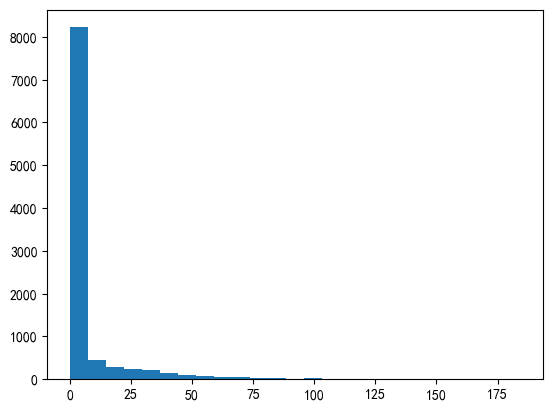

In [40]:
plt.hist(measures, bins=25);

Here we select a percentile and see the samples that does not fall into it

In [41]:
percent = 95

threshold_measure = np.percentile(np.array(measures), percent)
threshold_measure

40.162813568115254

In [42]:
model.eval()
problem_images = []

for img, label, lenght in tqdm(test_dataloader):
    img = img.to(device)
    label = label.to(device)
    with torch.no_grad():
        logits = model(img)
        log_probs = logits.permute(2, 0, 1)
        log_probs = log_probs.log_softmax(2).requires_grad_()
        ctc_input_lengths, ctc_target_lengths = sparse_tuple_for_ctc(predicted_length=config.LPRNet.PREDICTED_LENGTHS,
                                                                     gt_lengths=lenght)
        loss = ctc_loss(
            log_probs,
            label,
            input_lengths=ctc_input_lengths,
            target_lengths=ctc_target_lengths
        )
        preds = logits.cpu().detach().numpy()
        pred_plates, pred_labels = decode_function(preds, config.CHARS.LIST)

        true_labels = ['']
        for index in label[0]:
            true_labels[-1] += index2token[int(index)]

        cer_metric = cer(pred_plates, true_labels)

        if measure == 'loss':
            if loss.item() > threshold_measure:
                # add ture 
                problem_images.append((img[0].cpu(), label[0].tolist(), pred_plates[0], loss.item()))
        elif measure == 'cer':
            if float(cer) > threshold_measure:
                problem_images.append((img[0].cpu(), label[0].tolist(), pred_plates[0], float(cer_metric)))
len(problem_images)

  0%|          | 0/9999 [00:00<?, ?it/s]

500

Sort by cost

In [43]:
sorted_problem_images = sorted(problem_images, key=lambda x: x[-1])

Let's look at the most problematic picture

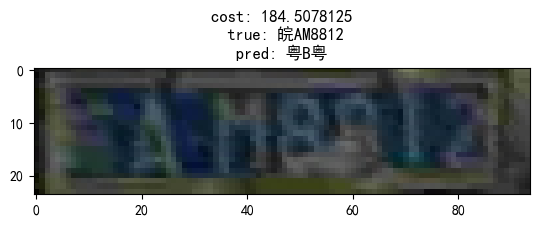

In [44]:
img, label, pred_plate, cost = sorted_problem_images[-1]
img = denormalize(img)

plt.imshow(img)
plt.title('cost: ' + str(cost) + '\n true: ' + ''.join([index2token[int(index)] for index in label]) + '\npred: ' + pred_plate);

And less

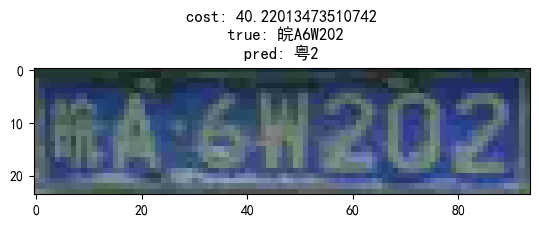

In [45]:
img, label, pred_plate, cost = sorted_problem_images[0]
img = denormalize(img)

plt.imshow(img)
plt.title('cost: ' + str(cost) + '\n true: ' + ''.join([index2token[int(index)] for index in label]) + '\npred: ' + pred_plate);

And now show all problematic images

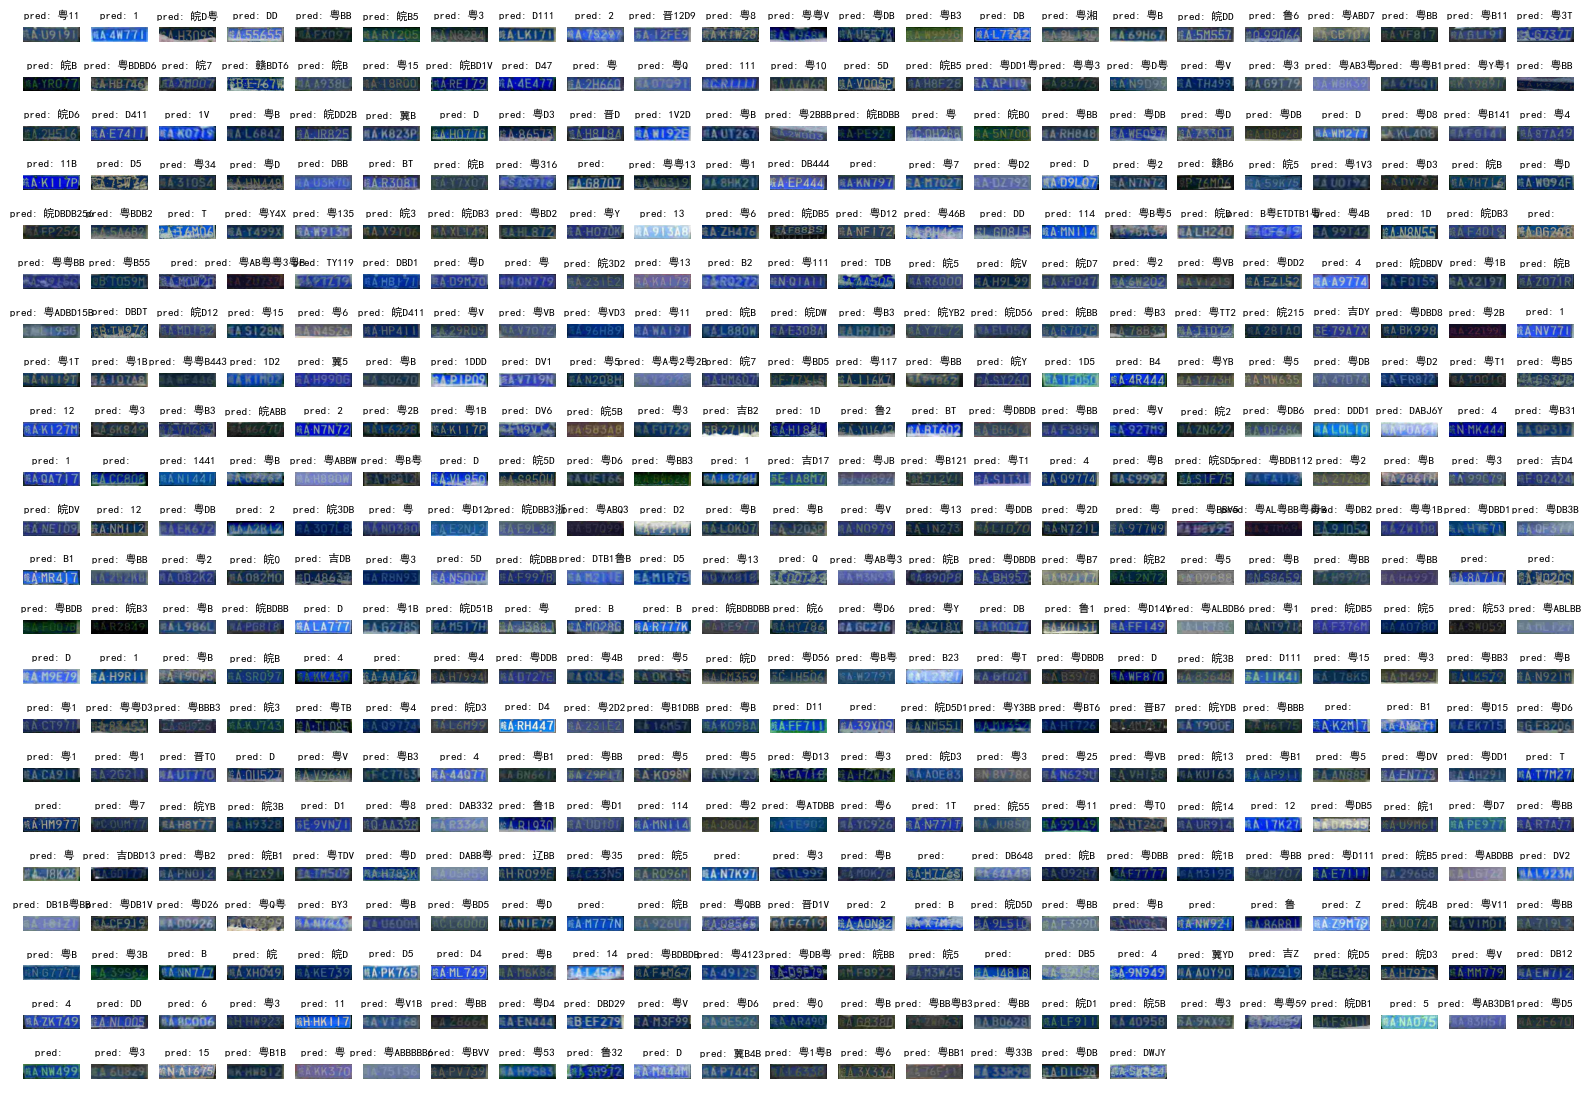

In [46]:
num_images = len(problem_images)
rows = int(num_images**0.5)
cols = num_images // rows + (num_images % rows > 0)

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(20, 14))

for i, ax in enumerate(axes.flat):
    if i < num_images:
        img, label, pred_plate, cost  = problem_images[i]
        img = denormalize(img)
        ax.imshow(img)
        ax.set_title('pred: ' + pred_plate, fontsize=8);
    ax.axis('off')

plt.show()

Conclusions: It can be seen from the erroneous numbers that they all differ from the standard type of number (blue background and white letters with numbers). I can assume that to solve this problem, it is necessary to use augmentation on existing numbers. In turn, this will complicate the training of the model, but will provide a better generalization. Augmentation should affect color, numbers (for example, it could be T.ColorJitter). You can also collect more of these numbers to show the models that such numbers also exist, but this will be more expensive and much less effective.